# Example Ensembles: Australian Credit Card Assessment

In this example it will be compared 3 classifiers:
- Multilayer perceptron.
- Ensemble trained with Negative Correlation (Xin Yao, 1999).
- Ensemble trained with Correntropy.

## Data

This data base concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.
  
- Number of Instances: 690
- Number of Attributes: 14 + class attribute
- Attribute Information:   THERE ARE 6 NUMERICAL AND 8 CATEGORICAL ATTRIBUTES.
- Exist 2 classes and its distribution is:
    * +: 307 (44.5%)    CLASS 2
    * -: 383 (55.5%)    CLASS 1
- there are 6 numerical and 8 categorical attributes. the labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.

- Missing Attribute Values: 37 cases (5%) HAD one or more missing values. The missing values from particular attributes WERE:
    * A1:  12
    * A2:  12
    * A4:   6
    * A5:   6
    * A6:   9
    * A7:   9
    * A14: 13
 
  These were replaced by the mode of the attribute (categorical) and mean of the attribute (continuous)


In [1]:
import theano
import theano.tensor as T
import numpy as np
from theano.sandbox import cuda

theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

path_data = r'data\australian.dat'
data = np.genfromtxt(path_data, delimiter=' ')

classes_names = np.asarray(['clase 1', 'clase 2'], dtype='<U10')
data_input    = np.asarray(data[:, 0:-1], dtype=theano.config.floatX)
data_target   = classes_names[np.asarray(data[:, -1:], dtype=int)]

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


### Experimental Setup

The data set was partitioned into two sets: a training set and a testing set. The first 518 examples were used for the training set, and the remaining 172 examples for the testing set. The input attributes were rescaled to between 0.0 and 1.0 by a linear function. (**Ensemble learning via negative correlation, Y. Liua, X. Yao**)

In [2]:
from sklearn import preprocessing

data_input_norm = preprocessing.MinMaxScaler().fit_transform(data_input)

input_train = data_input_norm[0:517]
input_test = data_input_norm[518:690]
target_train = data_target[0:517]
target_test = data_target[518:690]

## Training MLP

This model has ten neurons in hidden layer and the output layer two neurons with **one hot encoding**. The cost function is MSE and update function is Stochastic gradient descendent. 

In [3]:
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
from deepensemble.metrics import FactoryMetrics

mlp = Sequential("mlp", "classifier", classes_names)
mlp.add_layer(Dense(n_input=data_input.shape[1], n_output=40, activation=T.nnet.sigmoid))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
mlp.append_cost(mse)
mlp.set_update(sgd, learning_rate=0.1)
mlp.compile()

metrics_mlp = FactoryMetrics.get_metric(mlp)

max_epoch = 250
validation_jump = 5

for i in range(25):                      
    # training
    metric = mlp.fit(input_train, target_train, max_epoch=max_epoch, batch_size=32)
    # Compute metrics
    metrics_mlp.append_prediction(target_test, mlp.predict(input_test))
    metrics_mlp.append_metric(metric)
    
    # Reset parameters
    mlp.reset()

print("FINISHED MLP!")

Start Compile mlp  - elapsed: 1.32 [s]
mlp - epoch:[###############.....] 190/250 elapsed: 1.96[s] - left: 0.62[s] 
mlp - epoch:[############........] 150/250 elapsed: 1.54[s] - left: 1.02[s] 
mlp - epoch:[##############......] 180/250 elapsed: 1.79[s] - left: 0.69[s] 
mlp - epoch:[##############......] 180/250 elapsed: 1.86[s] - left: 0.72[s] 
mlp - epoch:[##############......] 180/250 elapsed: 1.90[s] - left: 0.73[s] 
mlp - epoch:[################....] 200/250 elapsed: 2.15[s] - left: 0.54[s] 
mlp - epoch:[##############......] 180/250 elapsed: 1.92[s] - left: 0.74[s] 
mlp - epoch:[############........] 160/250 elapsed: 1.69[s] - left: 0.95[s] 
mlp - epoch:[####################] 250/250 elapsed: 2.59[s] - left: 0.00[s] 
mlp - epoch:[##########..........] 130/250 elapsed: 1.40[s] - left: 1.29[s] 
mlp - epoch:[################....] 210/250 elapsed: 2.16[s] - left: 0.41[s] 
mlp - epoch:[#############.......] 170/250 elapsed: 1.81[s] - left: 0.85[s] 
mlp - epoch:[############........] 15

## Results MLP

             precision    recall  f1-score   support

    clase 1       0.91      0.82      0.86      2525
    clase 2       0.78      0.88      0.83      1775

avg / total       0.86      0.85      0.85      4300



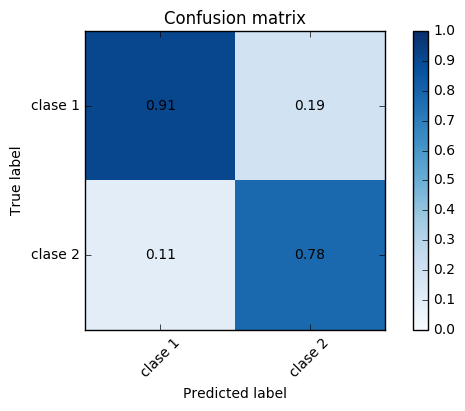

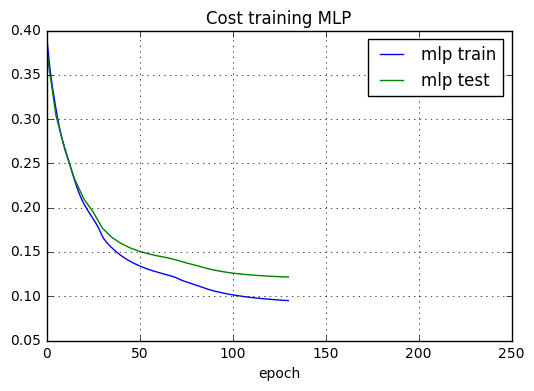

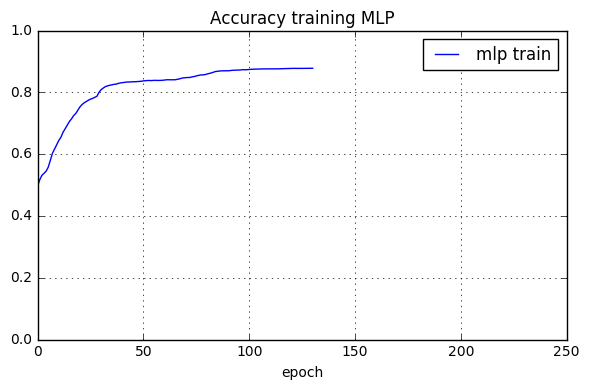

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_mlp.classification_report()
metrics_mlp.plot_confusion_matrix()
metrics_mlp.plot_cost(max_epoch, "Cost training MLP")
metrics_mlp.plot_score(max_epoch, "Accuracy training MLP")

plt.tight_layout()

## Ensemble

In [5]:
from deepensemble.models import EnsembleModel
from deepensemble.combiner import *

# Create Ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(4):
    net = Sequential("net%d_ens" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble.append_model(net)

ensemble.set_combiner(PluralityVotingCombiner())
ensemble.compile(fast=False)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

for i in range(25):                      
    # training
    metrics = ensemble.fit(input_train, target_train,
                            max_epoch=max_epoch, batch_size=32)
    # Compute metrics
    metrics_ensemble.append_prediction(target_test, ensemble.predict(input_test))
    metrics_ensemble.append_prediction_per_model(input_test, target_test)
    metrics_ensemble.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble.reset()

print("FINISHED!")

Start Compile Ensemble  - elapsed: 4.17 [s]
Ensemble - epoch:[####################] 250/250 elapsed: 7.30[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.68[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.56[s] - left: 0.00[s] 
Ensemble - epoch:[###################.] 240/250 elapsed: 7.01[s] - left: 0.29[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.16[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.56[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.33[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.50[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.36[s] - left: 0.00[s] 
Ensemble - epoch:[####################] 250/250 elapsed: 7.45[s] - left: 0.00[s] 
Ensemble - epoch:[################....] 210/250 elapsed: 5.86[s] - left: 1.11[s] 
Ensemble - epoch:[################....] 200/250 elapse

### Result Ensemble

             precision    recall  f1-score   support

    clase 1       0.92      0.82      0.87      2525
    clase 2       0.78      0.90      0.83      1775

avg / total       0.86      0.85      0.85      4300

Correlation Coefficient:
-------------------------------------------------------
           net0_ens   net1_ens   net2_ens   net3_ens   
-------------------------------------------------------
net0_ens     1.0000     0.7248     0.7464     0.7476   
net1_ens     0.7248     1.0000     0.6871     0.6850   
net2_ens     0.7464     0.6871     1.0000     0.7334   
net3_ens     0.7476     0.6850     0.7334     1.0000   

Disagreement:
-------------------------------------------------------
           net0_ens   net1_ens   net2_ens   net3_ens   
-------------------------------------------------------
net0_ens     0.1702     0.1833     0.1684     0.1670   
net1_ens     0.1702     0.1833     0.1684     0.1670   
net2_ens     0.1702     0.1833     0.1684     0.1670   
net3_ens     0.17

<function matplotlib.pyplot.tight_layout>

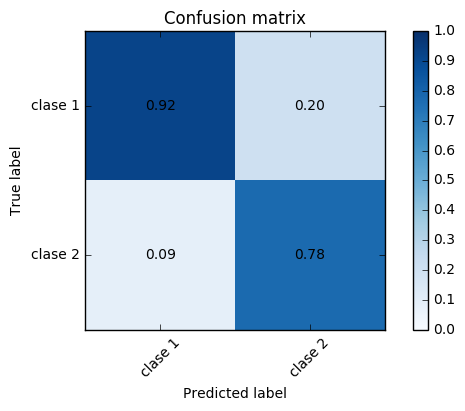

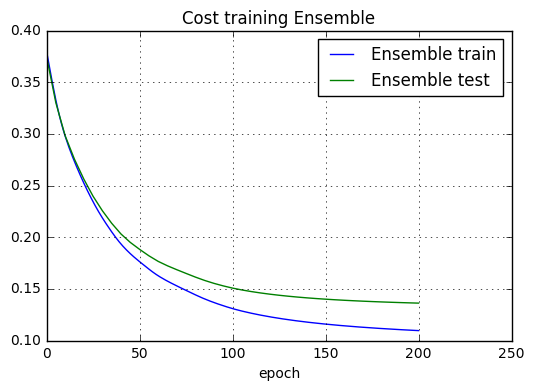

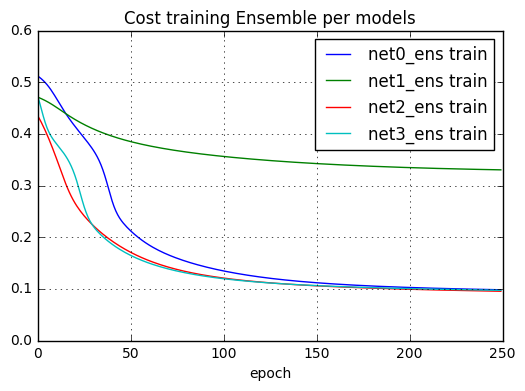

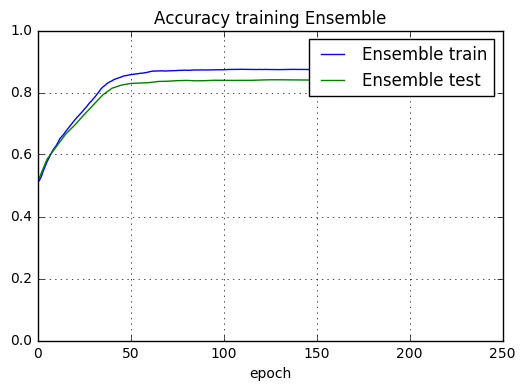

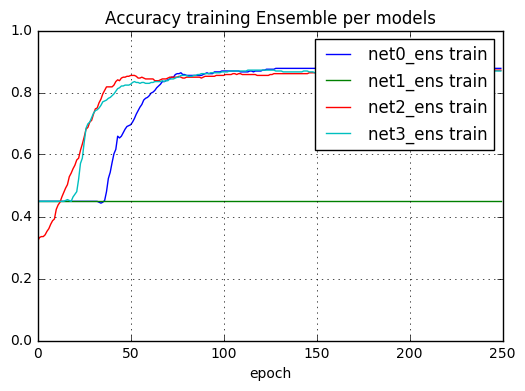

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble.classification_report()
metrics_ensemble.diversity_report()
metrics_ensemble.plot_confusion_matrix()
metrics_ensemble.plot_cost(max_epoch, "Cost training Ensemble")
metrics_ensemble.plot_cost_models(max_epoch, "Cost training Ensemble per models")
metrics_ensemble.plot_score(max_epoch, "Accuracy training Ensemble")
metrics_ensemble.plot_score_models(max_epoch, "Accuracy training Ensemble per models")

plt.tight_layout

## Training Ensemble - Negative Correlation (Xin Yao, 1999)

The ensemble architecture used in the experiments has four networks. Each individual network is a feedforward network with one hidden layer. Both the hidden node function and the output node function are defined by the logistic function. All the individual networks have ten hidden nodes. The number of training epochs was set to 250. The strength parameter of negative correlations was set to 1.0. These parameters were chosen after limited preliminary experiments. They are not meant to be optimal.

In [7]:
# Create Ensemble
ensemble_nc = EnsembleModel(name="Ensemble NC")

# Create models for ensemble
for i in range(4):
    net = Sequential("net%d_ens_nc" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_nc.append_model(net)

ensemble_nc.add_cost_ensemble(fun_cost=neg_corr, lamb_neg_corr=1.0)  # adds neg correlation in all models
ensemble_nc.set_combiner(PluralityVotingCombiner())
ensemble_nc.compile(fast=False)

metrics_ensemble_nc = FactoryMetrics.get_metric(ensemble_nc)

for i in range(25):                      
    # training
    metrics = ensemble_nc.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32)
    # Compute metrics
    metrics_ensemble_nc.append_prediction(target_test, ensemble_nc.predict(input_test))
    metrics_ensemble_nc.append_prediction_per_model(input_test, target_test)
    metrics_ensemble_nc.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_nc.reset()

print("FINISHED!")

Start Compile Ensemble NC  - elapsed: 5.75 [s]
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.48[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.63[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.52[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.67[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.66[s] - left: 0.00[s] 
Ensemble NC - epoch:[###################.] 240/250 elapsed: 7.15[s] - left: 0.30[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.47[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.61[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 8.08[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.69[s] - left: 0.00[s] 
Ensemble NC - epoch:[####################] 250/250 elapsed: 7.67[s] - left: 0.00[s] 
Ensemble NC - epoc

### Results Ensemble - Negative Correlation

             precision    recall  f1-score   support

    clase 1       0.92      0.82      0.87      2525
    clase 2       0.78      0.90      0.83      1775

avg / total       0.86      0.85      0.85      4300

Correlation Coefficient:
----------------------------------------------------------------------
              net0_ens_nc   net1_ens_nc   net2_ens_nc   net3_ens_nc   
----------------------------------------------------------------------
net0_ens_nc        1.0000        0.7952        0.7835        0.7884   
net1_ens_nc        0.7952        1.0000        0.8086        0.7889   
net2_ens_nc        0.7835        0.8086        1.0000        0.8040   
net3_ens_nc        0.7884        0.7889        0.8040        1.0000   

Disagreement:
----------------------------------------------------------------------
              net0_ens_nc   net1_ens_nc   net2_ens_nc   net3_ens_nc   
----------------------------------------------------------------------
net0_ens_nc        0.1570        0.

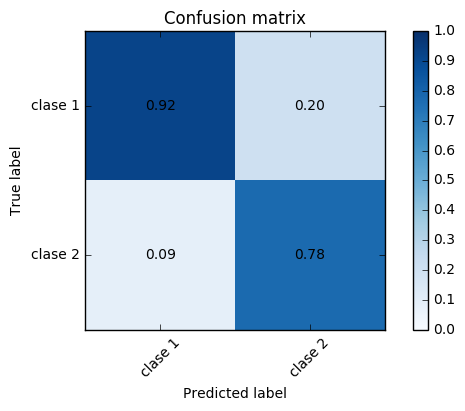

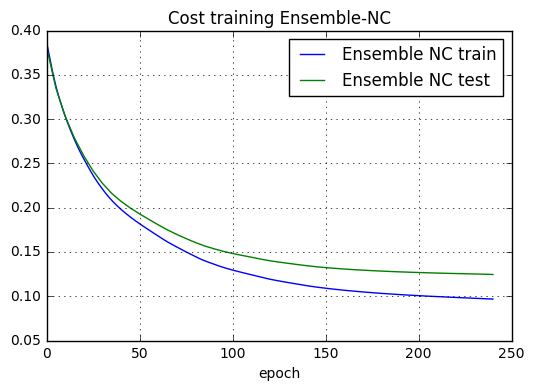

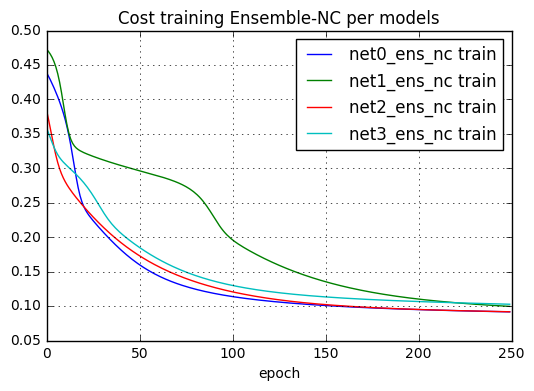

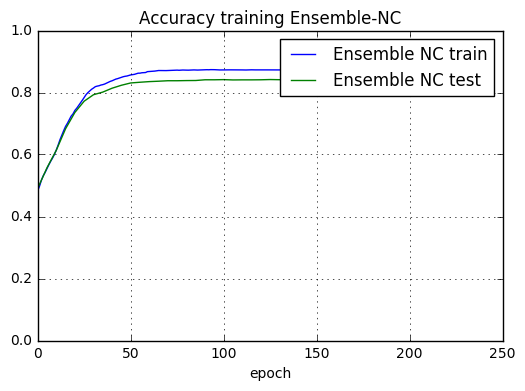

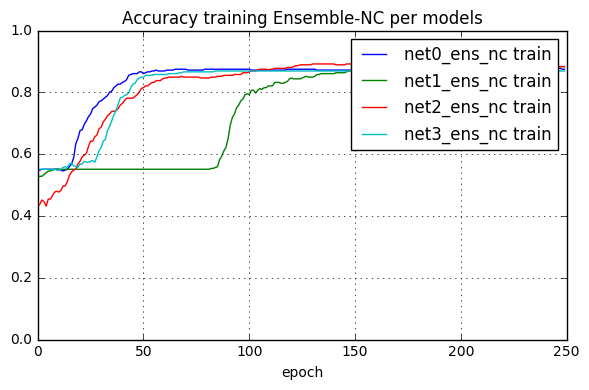

In [8]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble_nc.classification_report()
metrics_ensemble_nc.diversity_report()
metrics_ensemble_nc.plot_confusion_matrix()
metrics_ensemble_nc.plot_cost(max_epoch, "Cost training Ensemble-NC")
metrics_ensemble_nc.plot_cost_models(max_epoch, "Cost training Ensemble-NC per models")
metrics_ensemble_nc.plot_score(max_epoch, "Accuracy training Ensemble-NC")
metrics_ensemble_nc.plot_score_models(max_epoch, "Accuracy training Ensemble-NC per models")

plt.tight_layout()

## Training Ensemble - Correntropy

In [21]:
# Create Ensemble
ensemble_corrpy = EnsembleModel(name="Ensemble Correntropy")

# Create models for ensemble
for i in range(4):
    net = Sequential("net%d_ens_corrpy" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_corrpy.append_model(net)

# ensemble_corrpy.add_cost_ensemble(fun_cost=correntropy_cost, lamb_corr=1.0, s=10)  # adds correntropy cost in all models
ensemble_corrpy.set_combiner(PluralityVotingCombiner())
ensemble_corrpy.compile(fast=False)

metrics_ensemble_corrpy = FactoryMetrics.get_metric(ensemble_corrpy)

for i in range(2):                      
    # training
    metrics = ensemble_corrpy.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32)
    # Compute metrics
    metrics_ensemble_corrpy.append_prediction(target_test, ensemble_corrpy.predict(input_test))
    metrics_ensemble_corrpy.append_prediction_per_model(input_test, target_test)
    metrics_ensemble_corrpy.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_corrpy.reset()

print("FINISHED!")

Start Compile Ensemble Correntropy  - elapsed: 4.10 [s]
Ensemble Correntropy - epoch:[####################] 250/250 elapsed: 7.63[s] - left: 0.00[s] 
Ensemble Correntropy - epoch:[####################] 250/250 elapsed: 8.03[s] - left: 0.00[s] 
FINISHED!


### Results Ensemble - Correntropy

             precision    recall  f1-score   support

    clase 1       0.88      0.83      0.85       202
    clase 2       0.77      0.85      0.81       142

avg / total       0.84      0.83      0.84       344

Correlation Coefficient:
------------------------------------------------------------------------------------------
                  net0_ens_corrpy   net1_ens_corrpy   net2_ens_corrpy   net3_ens_corrpy   
------------------------------------------------------------------------------------------
net0_ens_corrpy            1.0000            0.3219            0.7325            0.8059   
net1_ens_corrpy            0.3219            1.0000            0.3626            0.3570   
net2_ens_corrpy            0.7325            0.3626            1.0000            0.7935   
net3_ens_corrpy            0.8059            0.3570            0.7935            1.0000   

Disagreement:
------------------------------------------------------------------------------------------
                 

<function matplotlib.pyplot.tight_layout>

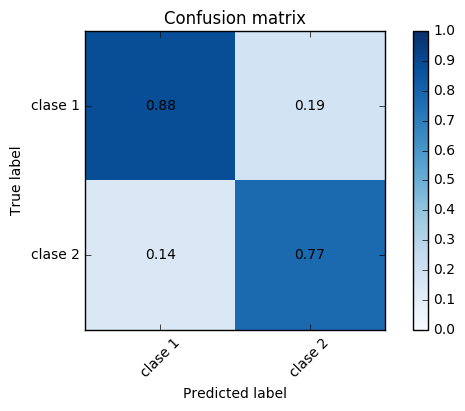

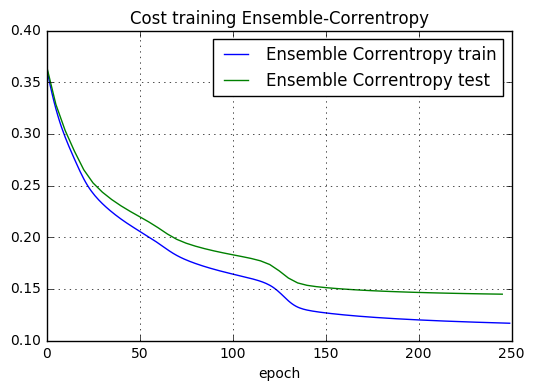

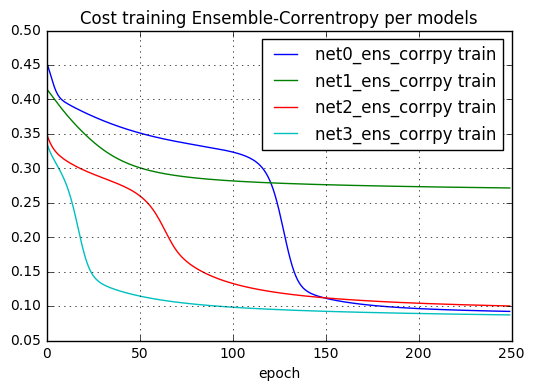

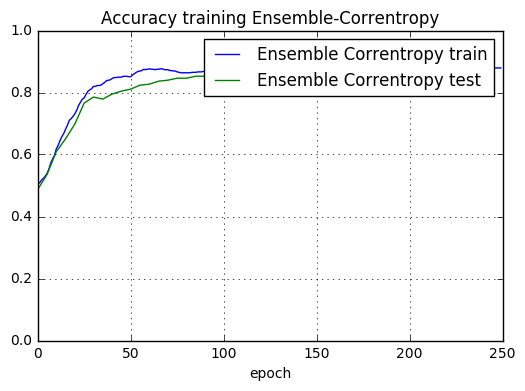

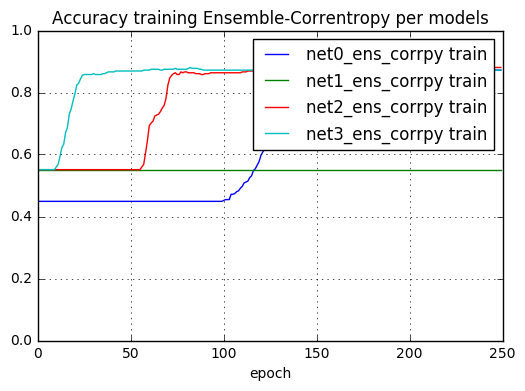

In [22]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble_corrpy.classification_report()
metrics_ensemble_corrpy.diversity_report()
metrics_ensemble_corrpy.plot_confusion_matrix()
metrics_ensemble_corrpy.plot_cost(max_epoch, "Cost training Ensemble-Correntropy")
metrics_ensemble_corrpy.plot_cost_models(max_epoch, "Cost training Ensemble-Correntropy per models")
metrics_ensemble_corrpy.plot_score(max_epoch, "Accuracy training Ensemble-Correntropy")
metrics_ensemble_corrpy.plot_score_models(max_epoch, "Accuracy training Ensemble-Correntropy per models")

plt.tight_layout